TensorFlow opublikował Speech Commands Datasets. Baza danych zawiera 65 tysięcy jednosekundowych nagrań 30 krótkich słów w języku angielskim, wypowiedzianych przez kilka ttsięcy różnych osób. W trakcie laboratorium zostaną użyte głębokie sieci neuronowe do rozpoznawania tych słów.

Baza nagrań może być pobrana stąd [tutaj](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).

**Implementacja modelu Speech-to-Text w Python'ie od podstaw**

**Import niezbędnych bibliotek**

W pierwszej kolejności importujemy biblioteki niezbędne do przetwarzania analizowanych danych. LibROSA i SciPy są bibiotekami Python'a używanymi do przetwarzania sygnałów audio.

In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [2]:
labels = ['happy', 'right', 'down', 'six', 'zero']
train_audio_path = 'train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

happy
right
down
six
zero


In [9]:
import random

def change_pitch_and_speed(sample):
    new_sample = sample.copy()
    speed_fac = np.random.uniform(low=0.8, high = 1.2)
    tmp = np.interp(np.arange(0,len(new_sample),speed_fac),np.arange(0,len(new_sample)),new_sample)
    minlen = min(new_sample.shape[0], tmp.shape[0])
    new_sample *= 0
    new_sample[0:minlen] = tmp[0:minlen]
    return new_sample

def change_value(sample):
    new_sample = sample.copy()
    dyn_change = np.random.uniform(low=0.5,high=3)
    new_sample = new_sample * dyn_change
    return new_sample

def add_white_noise(sample):
    new_sample = sample.copy()
    noise_amp = 0.04*np.random.uniform()*np.amax(new_sample)
    new_sample = new_sample.astype('float32') + noise_amp * np.random.normal(size=new_sample.shape[0])
    return new_sample

def shift_sample(sample):
    new_sample = sample.copy()
    timeshift_fac = 0.4*(np.random.uniform()-0.5)
    start = int(new_sample.shape[0] * timeshift_fac)
    if (start > 0):
        new_sample = np.pad(new_sample,(start,0),mode='constant')[0:new_sample.shape[0]]
    else:
        new_sample = np.pad(new_sample,(0,-start),mode='constant')[0:new_sample.shape[0]]
    return new_sample


def data_augmentation(x_tr, y_tr):
    x_tr_copy = x_tr.copy()
    y_tr_copy = y_tr.copy()
    for i in range(len(x_tr_copy)):
        print(i,'/',len(x_tr_copy))
        sample = x_tr_copy[i]
        label = y_tr_copy[i]
        sample = sample.reshape(8000)
        s1 = change_pitch_and_speed(sample).reshape(8000,1)
        s2 = change_value(sample).reshape(8000,1)
        s3 = add_white_noise(sample).reshape(8000,1)
        s4 = shift_sample(sample).reshape(8000,1)
        x_tr = np.vstack((x_tr, np.array([s1,s2,s3,s4])))
        y_tr = np.vstack((y_tr, np.array([label,label,label,label])))
    return x_tr, y_tr
    
def create_word_list(word):
    return [all_wave[i] for i in range(len(all_wave)) if all_label[i] == word]

word_wave = {}
for word in labels:
    word_wave[word] = create_word_list(word)
    random.shuffle(word_wave[word])
    print(len(word_wave[word]))
    
valid_wave = []
valid_label = []

test_wave = []
test_label = []
for word in labels:
    valid_wave += word_wave[word][-200:]
    valid_label += 200*[word]
    test_wave += word_wave[word][-700:-200]
    test_label += 500*[word]
    
training_waves = []
training_labels = []
for word in labels:
    training_waves += word_wave[word][:400]
    training_labels += 400*[word]

1549
2155
2152
2199
2203


Konwertujemy etykiety tekstowe do kodów całkowitoliczbowych, wymaganych do treningu klasyfikatora:

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test = le.fit_transform(test_label)
y_valid = le.transform(valid_label)
y_train = le.transform(training_labels)
classes= list(le.classes_)

Zaczyna się magia frameworku keras...

Konwertujemy całkowitoliczbowe etykiery do jednego wektora:

In [11]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test, num_classes=len(labels))
y_valid = np_utils.to_categorical(y_valid, num_classes=len(labels))
y_train = np_utils.to_categorical(y_train, num_classes=len(labels))

Przerabiamy macierze 2D na 3D ponieważ takiego wejścia spodziewa się sieć, która będzie użyta do rozpoznawania komend głosowych:

In [12]:
import sklearn
valid_wave = np.array(valid_wave).reshape(-1,8000,1)
test_wave = np.array(test_wave).reshape(-1,8000,1)
training_waves = np.array(training_waves).reshape(-1,8000,1)
print(len(valid_wave))
print(len(y_valid))

valid_wave, y_valid = sklearn.utils.shuffle(valid_wave, y_valid)
test_wave, y_test = sklearn.utils.shuffle(test_wave, y_test)
training_waves, y_train = sklearn.utils.shuffle(training_waves, y_train)

training_waves_little = training_waves.copy()
y_train_little = y_train.copy()

print(classes[np.argmax(y_valid[0])])
ipd.Audio(valid_wave[1].ravel(), rate=8000)
training_waves, y_train = data_augmentation(training_waves, y_train)

1000
1000
right
0 / 2000
1 / 2000
2 / 2000
3 / 2000
4 / 2000
5 / 2000
6 / 2000
7 / 2000
8 / 2000
9 / 2000
10 / 2000
11 / 2000
12 / 2000
13 / 2000
14 / 2000
15 / 2000
16 / 2000
17 / 2000
18 / 2000
19 / 2000
20 / 2000
21 / 2000
22 / 2000
23 / 2000
24 / 2000
25 / 2000
26 / 2000
27 / 2000
28 / 2000
29 / 2000
30 / 2000
31 / 2000
32 / 2000
33 / 2000
34 / 2000
35 / 2000
36 / 2000
37 / 2000
38 / 2000
39 / 2000
40 / 2000
41 / 2000
42 / 2000
43 / 2000
44 / 2000
45 / 2000
46 / 2000
47 / 2000
48 / 2000
49 / 2000
50 / 2000
51 / 2000
52 / 2000
53 / 2000
54 / 2000
55 / 2000
56 / 2000
57 / 2000
58 / 2000
59 / 2000
60 / 2000
61 / 2000
62 / 2000
63 / 2000
64 / 2000
65 / 2000
66 / 2000
67 / 2000
68 / 2000
69 / 2000
70 / 2000
71 / 2000
72 / 2000
73 / 2000
74 / 2000
75 / 2000
76 / 2000
77 / 2000
78 / 2000
79 / 2000
80 / 2000
81 / 2000
82 / 2000
83 / 2000
84 / 2000
85 / 2000
86 / 2000
87 / 2000
88 / 2000
89 / 2000
90 / 2000
91 / 2000
92 / 2000
93 / 2000
94 / 2000
95 / 2000
96 / 2000
97 / 2000
98 / 2000
99 /

754 / 2000
755 / 2000
756 / 2000
757 / 2000
758 / 2000
759 / 2000
760 / 2000
761 / 2000
762 / 2000
763 / 2000
764 / 2000
765 / 2000
766 / 2000
767 / 2000
768 / 2000
769 / 2000
770 / 2000
771 / 2000
772 / 2000
773 / 2000
774 / 2000
775 / 2000
776 / 2000
777 / 2000
778 / 2000
779 / 2000
780 / 2000
781 / 2000
782 / 2000
783 / 2000
784 / 2000
785 / 2000
786 / 2000
787 / 2000
788 / 2000
789 / 2000
790 / 2000
791 / 2000
792 / 2000
793 / 2000
794 / 2000
795 / 2000
796 / 2000
797 / 2000
798 / 2000
799 / 2000
800 / 2000
801 / 2000
802 / 2000
803 / 2000
804 / 2000
805 / 2000
806 / 2000
807 / 2000
808 / 2000
809 / 2000
810 / 2000
811 / 2000
812 / 2000
813 / 2000
814 / 2000
815 / 2000
816 / 2000
817 / 2000
818 / 2000
819 / 2000
820 / 2000
821 / 2000
822 / 2000
823 / 2000
824 / 2000
825 / 2000
826 / 2000
827 / 2000
828 / 2000
829 / 2000
830 / 2000
831 / 2000
832 / 2000
833 / 2000
834 / 2000
835 / 2000
836 / 2000
837 / 2000
838 / 2000
839 / 2000
840 / 2000
841 / 2000
842 / 2000
843 / 2000
844 / 2000

1458 / 2000
1459 / 2000
1460 / 2000
1461 / 2000
1462 / 2000
1463 / 2000
1464 / 2000
1465 / 2000
1466 / 2000
1467 / 2000
1468 / 2000
1469 / 2000
1470 / 2000
1471 / 2000
1472 / 2000
1473 / 2000
1474 / 2000
1475 / 2000
1476 / 2000
1477 / 2000
1478 / 2000
1479 / 2000
1480 / 2000
1481 / 2000
1482 / 2000
1483 / 2000
1484 / 2000
1485 / 2000
1486 / 2000
1487 / 2000
1488 / 2000
1489 / 2000
1490 / 2000
1491 / 2000
1492 / 2000
1493 / 2000
1494 / 2000
1495 / 2000
1496 / 2000
1497 / 2000
1498 / 2000
1499 / 2000
1500 / 2000
1501 / 2000
1502 / 2000
1503 / 2000
1504 / 2000
1505 / 2000
1506 / 2000
1507 / 2000
1508 / 2000
1509 / 2000
1510 / 2000
1511 / 2000
1512 / 2000
1513 / 2000
1514 / 2000
1515 / 2000
1516 / 2000
1517 / 2000
1518 / 2000
1519 / 2000
1520 / 2000
1521 / 2000
1522 / 2000
1523 / 2000
1524 / 2000
1525 / 2000
1526 / 2000
1527 / 2000
1528 / 2000
1529 / 2000
1530 / 2000
1531 / 2000
1532 / 2000
1533 / 2000
1534 / 2000
1535 / 2000
1536 / 2000
1537 / 2000
1538 / 2000
1539 / 2000
1540 / 2000
1541

**Wybór zbioru treningowego i walidacyjnego**

Użyjemy 80% danych do treningu, a pozostałe 20% do walidacji wytrenowanego modelu:


**Wybór architektury sieci dla problemu rozpozawaia komed głosowych**

Model speech-to-text zostanie zbudowany w oparciu o sieć conv1d. Conv1d to konwolucyjna sieć neuronowa, wykonująca konwolucję tylko w jedym wymiarze. 

**Budowa modelu**

Budujemy model korzystając z API frameworku Keras.

In [13]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

def build_new_model():
    K.clear_session()
    inputs = Input(shape=(8000,1))

    #First Conv1D layer
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Third Conv1D layer
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Fourth Conv1D layer
    conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Flatten layer
    conv = Flatten()(conv)

    #Dense Layer 1
    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    #Dense Layer 2
    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)
    outputs = Dense(len(labels), activation='softmax')(conv)
    model = Model(inputs, outputs)
    
    return model

In [14]:
model = build_new_model()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
history_little = model.fit(training_waves_little, y_train_little ,epochs=6, callbacks=[es], batch_size=32, validation_data=(valid_wave,y_valid))
model.save('model_little')

model = build_new_model()
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
history_data_augmentation = model.fit(training_waves, y_train ,epochs=6, callbacks=[es], batch_size=32, validation_data=(valid_wave,y_valid))
model.save('model_data_augmentation')

Train on 2000 samples, validate on 1000 samples
Epoch 1/6
2000/2000 [==============================] - 9s 5ms/step - loss: 1.5804 - accuracy: 0.2525 - val_loss: 1.5669 - val_accuracy: 0.3320
Epoch 2/6
2000/2000 [==============================] - 9s 5ms/step - loss: 1.4871 - accuracy: 0.3565 - val_loss: 1.4510 - val_accuracy: 0.3780
Epoch 3/6
2000/2000 [==============================] - 10s 5ms/step - loss: 1.2911 - accuracy: 0.4750 - val_loss: 1.3188 - val_accuracy: 0.4370
Epoch 4/6
2000/2000 [==============================] - 10s 5ms/step - loss: 1.1455 - accuracy: 0.5305 - val_loss: 1.0813 - val_accuracy: 0.5730
Epoch 5/6
2000/2000 [==============================] - 9s 4ms/step - loss: 1.0150 - accuracy: 0.5755 - val_loss: 1.1175 - val_accuracy: 0.5590
Epoch 6/6
2000/2000 [==============================] - 9s 4ms/step - loss: 0.9319 - accuracy: 0.6135 - val_loss: 0.9146 - val_accuracy: 0.6520
Train on 10000 samples, validate on 1000 samples
Epoch 1/6
10000/10000 [====================

**Wykres diagnostyczny**

Wizualizacja pomaga nam zrozumieć, jak działa sieć na danych treningiwych, a jak na walidacyjnych:

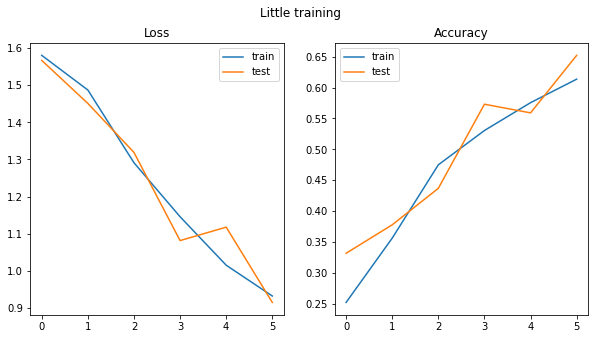

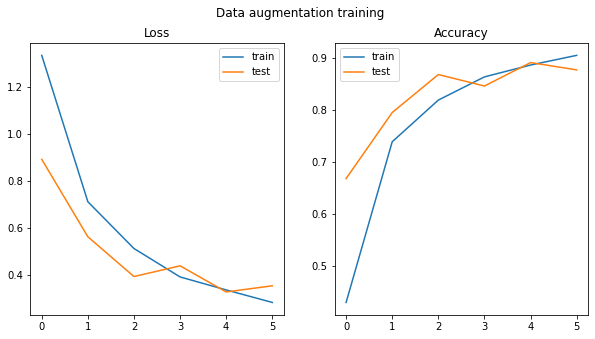

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(history_little.history['loss'], label='train')
ax1.plot(history_little.history['val_loss'], label='test')
ax1.legend()
ax1.set_title("Loss")
ax2.plot(history_little.history['accuracy'], label='train')
ax2.plot(history_little.history['val_accuracy'], label='test')
ax2.legend()
ax2.set_title("Accuracy")
fig.suptitle("Little training")
fig.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(history_data_augmentation.history['loss'], label='train')
ax1.plot(history_data_augmentation.history['val_loss'], label='test')
ax1.legend()
ax1.set_title("Loss")
ax2.plot(history_data_augmentation.history['accuracy'], label='train')
ax2.plot(history_data_augmentation.history['val_accuracy'], label='test')
ax2.legend()
ax2.set_title("Accuracy")
fig.suptitle("Data augmentation training")
fig.show()

Definiujemy funkcję, która znajduje wyraz odpowiadający sygnałowi audio::

In [16]:
def predict(audio, model_name):
    prob=model_name.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [17]:
from prettytable import PrettyTable
def show_table(content, labels, title):
    table = PrettyTable()
    table.field_names = labels
    table.title = title
    if not title == "Confusion Table in percentage":
        table.add_rows(content.astype('int'))
    else:
        table.add_rows(content)
    table._field_names.insert(0,"")
    table._align[""] = 'c' 
    table._valign[""] = 't' 
    for i, _ in enumerate(table._rows): 
        table._rows[i].insert(0, labels[i]) 
    print(table)

**Predykcja**
Sprawdzamy działanie wytrenowanej sieci na zbiorze testowym

In [18]:
from keras.models import load_model
from sklearn.metrics import classification_report
models = ["model_little", "model_data_augmentation"]
for model_name in models:
    model = load_model(model_name)
    real_value = []
    expected_value = []
    confusion_matrix = np.zeros((len(labels),len(labels)))
    for index in range(len(test_wave)):
        samples = test_wave[index].ravel()
        expected_value.append(classes[np.argmax(y_test[index])])
        real_value.append(predict(samples, model))
        column = classes.index(predict(samples, model))
        row = np.argmax(y_test[index])
        confusion_matrix[row][column] += 1
    print("-----------------------STATISTICS-FOR-"+model_name.upper()+"--------------------------")
    show_table(confusion_matrix, classes, "Confusion Table")
    show_table((confusion_matrix/len(test_wave)*100).round(2), classes, "Confusion Table in percentage")
    print(classification_report(expected_value, real_value, target_names=classes))
    print("\n------------------------------------------------------------------------\n\n")

-----------------------STATISTICS-FOR-MODEL_LITTLE--------------------------
+-------------------------------------------+
|              Confusion Table              |
+-------+------+-------+-------+-----+------+
|       | down | happy | right | six | zero |
+-------+------+-------+-------+-----+------+
|  down | 315  |   34  |   58  |  37 |  56  |
| happy |  20  |  386  |   13  |  76 |  5   |
| right |  84  |   10  |  306  |  82 |  18  |
|  six  |  1   |   27  |   41  | 428 |  3   |
|  zero | 197  |   13  |   58  |  34 | 198  |
+-------+------+-------+-------+-----+------+
+---------------------------------------------+
|        Confusion Table in percentage        |
+-------+------+-------+-------+-------+------+
|       | down | happy | right |  six  | zero |
+-------+------+-------+-------+-------+------+
|  down | 12.6 |  1.36 |  2.32 |  1.48 | 2.24 |
| happy | 0.8  | 15.44 |  0.52 |  3.04 | 0.2  |
| right | 3.36 |  0.4  | 12.24 |  3.28 | 0.72 |
|  six  | 0.04 |  1.08 |  1.64 | 